In [1]:
# Library Imports
# Data storing Imports
import numpy as np
import pandas as pd

# Clustering imports
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import hdbscan
import gower

# Function imports from other files
import data_preparation as dp

In [2]:
# Reading in data for testing
data = pd.read_csv('test_data/2020-05-01.csv')
data = data.drop_duplicates(subset=['equipRef','groupRef','navName','siteRef','typeRef','unit'])
print(data.shape)
print(data['unit'].unique())
data.head()

(4452, 8)
['ppm' '°C' 'omit' 'Pa' '%' 'ft/min' 'L/s' '_' 'L' 'A' 'kPa' 'psi' '°F'
 'kW' '%RH' 'min' 'W' 'V' 'kWh' 'm³' 'Hz' 'rpm']


,datetime,equipRef,groupRef,navName,siteRef,typeRef,unit,value
0,2020-05-01 00:00:01+00:00,EF-B02,Pharmacy Air Systems,EF_B02_RLD_CH1_3,Pharmacy,EF_B02_RLD_CH1_3,ppm,2.107125
1,2020-05-01 00:00:01+00:00,Heating Plant SBLR-1,Pharmacy Hydronic Systems,SB1_2_FGAS_INLET_T,Pharmacy,SB1_2_FGAS_INLET_T,°C,274.787537
2,2020-05-01 00:00:01+00:00,Rm 2340 VAV-2S008,Pharmacy Floor 2,Zone Temp,Pharmacy,VAV_2S008_RT_AV,°C,24.574572
3,2020-05-01 00:00:01+00:00,Rm B612 FC-B06,Pharmacy Floor 0,Discharge Fan Run Cmd,Pharmacy,FCU_B06_C,omit,True
4,2020-05-01 00:00:02+00:00,AHU-06,Pharmacy Air Systems,AHU6_SPACE_DP(MUX),Pharmacy,AHU6_SPACE_DP(MUX),Pa,7.981429


# Scaling values and encoding values and units
The function for scaling and encoding values is different from the one for scaling units so the resulting dataframes need to be merged

In [3]:
df_vals = dp.encode_and_scale_values(data)
df_units = dp.encode_units(data)
df = df_vals.merge(df_units.drop('value', axis=1), on=['datetime','equipRef','groupRef','navName','siteRef','typeRef', 'unit'])
df.head()

,datetime,equipRef,groupRef,navName,siteRef,typeRef,unit,value,cv_0,cv_1,...,unit_12,unit_13,unit_14,unit_15,unit_16,unit_17,unit_18,unit_19,unit_20,unit_21
0,2020-05-01 00:00:01+00:00,EF-B02,Pharmacy Air Systems,EF_B02_RLD_CH1_3,Pharmacy,EF_B02_RLD_CH1_3,ppm,2.107125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-05-01 00:00:01+00:00,Heating Plant SBLR-1,Pharmacy Hydronic Systems,SB1_2_FGAS_INLET_T,Pharmacy,SB1_2_FGAS_INLET_T,°C,274.787537,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-05-01 00:00:01+00:00,Rm 2340 VAV-2S008,Pharmacy Floor 2,Zone Temp,Pharmacy,VAV_2S008_RT_AV,°C,24.574572,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-05-01 00:00:01+00:00,Rm B612 FC-B06,Pharmacy Floor 0,Discharge Fan Run Cmd,Pharmacy,FCU_B06_C,omit,True,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-05-01 00:00:02+00:00,AHU-06,Pharmacy Air Systems,AHU6_SPACE_DP(MUX),Pharmacy,AHU6_SPACE_DP(MUX),Pa,7.981429,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.columns

Index(['datetime', 'equipRef', 'groupRef', 'navName', 'siteRef', 'typeRef',
       'unit', 'value', 'cv_0', 'cv_1', 'cv_2', 'cv_3', 'cv_4', 'cv_5', 'cv_6',
       'cv_7', 'cv_8', 'cv_9', 'sc_0', 'unit_0', 'unit_1', 'unit_2', 'unit_3',
       'unit_4', 'unit_5', 'unit_6', 'unit_7', 'unit_8', 'unit_9', 'unit_10',
       'unit_11', 'unit_12', 'unit_13', 'unit_14', 'unit_15', 'unit_16',
       'unit_17', 'unit_18', 'unit_19', 'unit_20', 'unit_21'],
      dtype='object')

# Calculating the Gower's distances
NOTE: Categorical observations are currently identified with 0 when none of the categories apply, I don't think this should be a problem since we can tell the gower_matrix function which columns are categorical, so it should know that 0 indicates the lack of a value rather than the presence of something else.

In [12]:
# Generating list of Booleans for identifying which columns are categorical and which aren't (pass in a list of columns that are continuous and the number predictor variables)
def make_categorical_list(cont_idxs, num_predictors):
    if type(cont_idxs)==int: cont_idxs = [cont_idxs]
    is_Cat = []
    for i in range(num_predictors):
        if i in cont_idxs:
            is_Cat.append(False)
        else:
            is_Cat.append(True)
    return is_Cat

In [13]:
# Function to simplify calculating Gower's distance (pass in the dataframe and the indexes of the columns that are categorical)
def calc_gowers(df, continuous_columns):
    catList = make_categorical_list(continuous_columns, len(df.columns)-8)
    data_np = df.iloc[:,8:].to_numpy()
    gow_dists = gower.gower_matrix(data_np, cat_features=catList)
    return gow_dists

In [14]:
gow_dists = calc_gowers(df, [10])
gow_dists

array([[0.0000000e+00, 6.0606256e-02, 6.0606077e-02, ..., 6.0606077e-02,
        6.0606077e-02, 6.0606077e-02],
       [6.0606256e-02, 0.0000000e+00, 1.8048814e-07, ..., 1.8170053e-07,
        1.8124335e-07, 1.7965388e-07],
       [6.0606077e-02, 1.8048814e-07, 0.0000000e+00, ..., 1.2123854e-09,
        7.5520851e-10, 8.3426427e-10],
       ...,
       [6.0606077e-02, 1.8170053e-07, 1.2123854e-09, ..., 0.0000000e+00,
        4.5717685e-10, 2.0466497e-09],
       [6.0606077e-02, 1.8124335e-07, 7.5520851e-10, ..., 4.5717685e-10,
        0.0000000e+00, 1.5894728e-09],
       [6.0606077e-02, 1.7965388e-07, 8.3426427e-10, ..., 2.0466497e-09,
        1.5894728e-09, 0.0000000e+00]], dtype=float32)

# Clustering Function
This function is intended for quick testing of various different clustering methods, some minimal "optimization" has been done on some of the clustering methods to make it so that they will work with the data provided. The items that have been "optimized" (for lack of a better word) are listed below:
* Agglomerative Clustering (agglom): linkage = 'complete'
* DBSCAN (dbscan): eps=0.06
* HDBSCAN (hdbscan): cluster_selection_epsilon=0.06

NOTE: kmeans doesn't actually account for account for the fact that most of the predictor variables are categorical (we could implement multidimensional scalling to do that). Furthermore many of the other clustering methods don't accept Gower's distance as input, but expect datasets of values, we could use MDS to get the data into a scale that can leverage the Gower's distances and thereby account for the fact that certain variables are categorical. I have tested MDS down at the bottom of this file and was able to get it to work. It provided a fring benefit of being able to visualize our data in some form for the first time.

In [83]:
# Function to quickly run various different clustering methods, look at the portion of the if statement to see what values each model type needs in order to run
## Available model types are: kmeans, agglom (agglomerative or hierarchical), dbscan
def cluster(df, clust_type, num_clusts = None, continuous_columns = None):
    if continuous_columns != None:
        # Calculate the Gower's distance, only required if there are continuous columns
        fit_data = calc_gowers(df, continuous_columns)
    if clust_type == 'kmeans':
        # Needs df, clust_type, num_clusts
        fit_data = df.iloc[:,8:].to_numpy()
        model = KMeans(n_clusters=num_clusts).fit(fit_data)
    elif clust_type == 'agglom':
        # Needs df, clust_type, num_clusts, continuous_columns
        model = AgglomerativeClustering(affinity='precomputed', linkage = 'complete', n_clusters=num_clusts).fit(fit_data)
    elif clust_type == 'dbscan':
        # Needs df, clust_type, continuous_columns
        model = DBSCAN(eps=0.06, min_samples=2, metric='precomputed').fit(gow_dists)
    elif clust_type == 'hdbscan':
        # Needs df, clust_type, continuous_columns
        model = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_epsilon=0.06).fit(gow_dists.astype('double'))
    else:
        print("Specified model type not available yet")
    try:
        print(silhouette_score(fit_data, model.labels_))
        return model.labels_
    except:
        print('Unable to calculate silhouette score for the given model')

test = cluster(df, 'hdbscan', continuous_columns = 10)
test_Clusts = pd.DataFrame(test, columns=["cluster"])
test_Clusts['cluster'].value_counts().sort_index()

0.91493356


-1        7
 0       59
 1       25
 2      135
 3      102
 4       90
 5      171
 6        9
 7        6
 8        9
 9       60
 10       7
 11     136
 12     610
 13    1340
 14      18
 15     239
 16     573
 17     232
 18     155
 19     469
Name: cluster, dtype: int64

# K-means Clustering
Note: K-means Clustering doesn't use Gower's distance

In [15]:
# Fitting the data with k-means clustering (doesn't use Gower's distance)
clusterVals = data_np
kmeans = KMeans(n_clusters=16).fit(clusterVals)
print(silhouette_score(clusterVals, kmeans.labels_))
# Summarising how many observations belong to each cluster
kClusts = pd.DataFrame(kmeans.labels_, columns=["cluster"])
kClusts['cluster'].value_counts().sort_index()

0.9706555036386533


0     1340
1      572
2      358
3      610
4      171
5      239
6      232
7      155
8      136
9      135
10      98
11      60
12      90
13     120
14      58
15      78
Name: cluster, dtype: int64

# Agglomerative Clustering
Agglomerative Clustering is the same thing as hierarchical clustering
### Testing Various Linkages and number of clusters

In [ ]:
# Fitting the data with Agglomerative clustering
linkage_options = ['single', 'average', 'complete']
max_clust = 25
silhouette_df = pd.DataFrame(columns=linkage_options, index=[i for i in range(2,max_clust+1)])
silhouettes = []
for link in linkage_options:
    for n_clust in range(2,max_clust+1):
        agglom = AgglomerativeClustering(affinity='precomputed', linkage = link, n_clusters=n_clust).fit(gow_dists)
        silhouette_df.loc[n_clust,link] = silhouette_score(gow_dists, agglom.labels_)

In [ ]:
silhouette_df

In [ ]:
#Identifying the top performing configuration from the above tests
cur_max = 'none'
cur_max_val = -2 # Worst case scenario is -1
for link in linkage_options:
    check_max = max(silhouette_df[link])
    if check_max >= cur_max_val:
        cur_max = link
        cur_max_val = check_max
max_idx = silhouette_df[cur_max].astype(float).idxmax()
print("Linkage for max silhouette score: "+cur_max+"\nNumber of clusters for max silhouette score: "+str(max_idx)+"\nMax silhouette score is: "+str(cur_max_val))

In [ ]:
# Plotting silhouette scores from above
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

cols = ['red','blue','green']
for i in range(0,3):
    plt.plot(silhouette_df[linkage_options[i]], color=cols[i])
plt.legend(linkage_options)
plt.show()

In [ ]:
# Plotting Dendrogram
### NOTE: This code was copy pasted from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html for testing purposes
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(affinity='precomputed', distance_threshold=0, n_clusters=None, linkage = 'complete')

model = model.fit(gow_dists)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.xticks(rotation=90)
plt.show()

### Fitting the best configuraiton from the for loop Grid Seach

In [ ]:
# Fitting best configuration from the for loop Grid Seach
agglom = AgglomerativeClustering(affinity='precomputed', linkage = cur_max, n_clusters=max_idx).fit(gow_dists)
# Printing the Silhouette_score for the best configuration from the for loop Grid Seach
print(silhouette_score(gow_dists, agglom.labels_))
# Summarising how many observations belong to each cluster
aggClusts = pd.DataFrame(agglom.labels_, columns=["cluster"])
aggClusts['cluster'].value_counts().sort_index()

### Fitting the best configuraiton from the for Dendrogram
From the dendrogram shown above it looks like there should be 8 clusters

In [ ]:
# Fitting best configuration from the dendrogram
agglom = AgglomerativeClustering(affinity='precomputed', linkage = 'complete', n_clusters=8).fit(gow_dists)
# Printing the Silhouette_score for the best configuration from the dendrogram
print(silhouette_score(gow_dists, agglom.labels_))
# Summarising how many observations belong to each cluster
aggClusts = pd.DataFrame(agglom.labels_, columns=["cluster"])
aggClusts['cluster'].value_counts().sort_index()

# Clustering with DBSCAN from sklearn

In [42]:
# Fitting the data with DBSCAN clustering
db_clust = DBSCAN(eps=0.06, min_samples=2, metric='precomputed').fit(gow_dists)
# Printing the cluster labels for each cluster
print(db_clust.labels_)
print(type(db_clust.labels_))
print(silhouette_score(gow_dists, db_clust.labels_))
clusts = pd.DataFrame(db_clust.labels_, columns=["cluster"])
clusts['cluster'].value_counts().sort_index()

[0 1 1 ... 1 1 1]
<class 'numpy.ndarray'>
0.96521753


0      136
1     1340
2      478
3      239
4      610
5        5
6      572
7      155
8       25
9      232
10      18
11       5
12       8
13      98
14      58
15       4
16      90
17     135
18     171
19       6
20      60
21       7
Name: cluster, dtype: int64

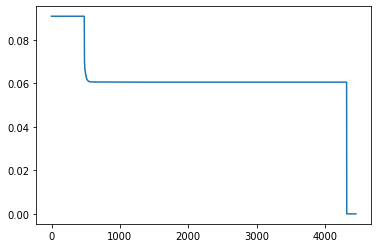

In [35]:
# k-distance plot for determining epsilon (looks like a value around 0.06 is appropriate here) (used for both DBSCAN and HDBSCAN)
from matplotlib import pyplot as plt
sorted_vals = gow_dists[0]
sorted_vals = sorted_vals[np.argsort(-gow_dists[0])]
plt.plot(sorted_vals)

# Clustering with HDBSCAN from hdbscan

In [81]:
hdb = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_epsilon=0.06).fit(gow_dists.astype('double'))
#hdbClusts = hdb
print(hdb.labels_)
print(silhouette_score(gow_dists, hdb.labels_))
hdbClusts = pd.DataFrame(hdb.labels_, columns=["cluster"])
hdbClusts['cluster'].value_counts().sort_index()

[11 13 13 ... 13 13 13]
0.91493356


-1        7
 0       59
 1       25
 2      135
 3      102
 4       90
 5      171
 6        9
 7        6
 8        9
 9       60
 10       7
 11     136
 12     610
 13    1340
 14      18
 15     239
 16     573
 17     232
 18     155
 19     469
Name: cluster, dtype: int64

# Multidimensional Scaling
Not sure if this will be of use but wanted to test since many of the clustering methods don't accept distances as inputs (requires the dataframe of values). MDS will allow us to scale the gower's distance data into a coordinate system. It will also allow us to plot our clusters since we can reduce dimensionality.

In [45]:
# MDS Import
from sklearn.manifold import MDS

# Scale the data down to 2 degrees
scaler = MDS(dissimilarity='precomputed')
data_2d = scaler.fit_transform(gow_dists)
data_2d.shape

(4452, 2)

In [55]:
# Make Data into a Dataframe
data_2d_df = pd.DataFrame(data=data_2d, columns = ['x','y'])
data_2d_df['cluster'] = clusts['cluster']
data_2d_df

,x,y,cluster
0,-0.024033,-0.041793,0
1,-0.003464,0.030393,1
2,-0.003464,0.030393,1
3,0.075207,0.015623,2
4,0.002778,-0.046273,3
...,...,...,...
4447,-0.003464,0.030393,1
4448,-0.003464,0.030393,1
4449,-0.003464,0.030393,1
4450,-0.003464,0.030393,1


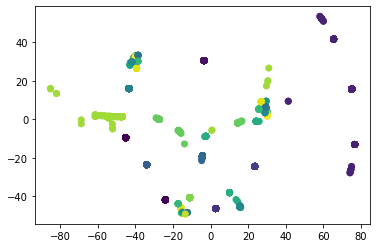

In [64]:
# Plotting the dbscan clusters (Fit pre-MDS)
plt.scatter(data_2d_df['x']*1000,data_2d_df['y']*1000, c=data_2d_df['cluster'])

In [67]:
data_2d_df.iloc[:,:2]
kmeans = KMeans(n_clusters=16).fit(data_2d_df.iloc[:,:2])
print(silhouette_score(clusterVals, kmeans.labels_))
# Summarising how many observations belong to each cluster
kClusts = pd.DataFrame(kmeans.labels_, columns=["cluster"])
kClusts['cluster'].value_counts().sort_index()

0.827408440097625


0      572
1     1340
2      610
3      329
4      232
5      167
6      153
7      190
8       77
9       70
10     273
11     165
12      56
13      82
14      80
15      56
Name: cluster, dtype: int64

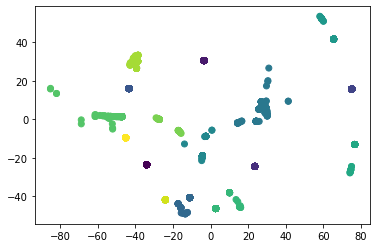

In [68]:
# k-means clustering (fit post-MDS)
plt.scatter(data_2d_df['x']*1000,data_2d_df['y']*1000, c=kClusts['cluster'])

In [70]:
# Fitting the data with DBSCAN clustering
db_clust = DBSCAN(eps=0.01, min_samples=2).fit(data_2d_df.iloc[:,:2])
# Printing the cluster labels for each cluster
print(db_clust.labels_)
print(type(db_clust.labels_))
print(silhouette_score(data_2d_df.iloc[:,:2], db_clust.labels_))
dbClusts = pd.DataFrame(db_clust.labels_, columns=["cluster"])
dbClusts['cluster'].value_counts().sort_index()

[0 1 1 ... 1 1 1]
<class 'numpy.ndarray'>
0.9346832764984514


0      247
1     1340
2      329
3      239
4      610
5       82
6       61
7      572
8      151
9      155
10       2
11     217
12     232
13      59
14      34
15      34
16      37
17      20
18      11
19      16
20       4
Name: cluster, dtype: int64

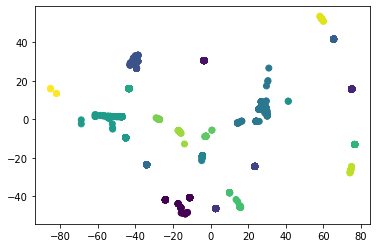

In [71]:
# DBSCAN Plot (fit post MDS)
plt.scatter(data_2d_df['x']*1000,data_2d_df['y']*1000, c=dbClusts['cluster'])

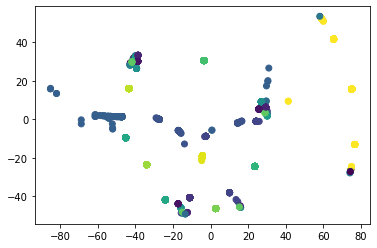

In [82]:
# HDBSCAN Plot (fit pre-MDS)
plt.scatter(data_2d_df['x']*1000,data_2d_df['y']*1000, c=hdbClusts['cluster'])

In [84]:
# Scale the data down to 3 degrees
scaler = MDS(n_components=3,dissimilarity='precomputed')
data_3d = scaler.fit_transform(gow_dists)
data_3d.shape

(4452, 3)

In [87]:
# Make Data into a Dataframe
data_3d_df = pd.DataFrame(data=data_3d, columns = ['x','y','z'])
data_3d_df

,x,y,z
0,-0.002976,-0.010623,0.042916
1,-0.020873,-0.001612,-0.023568
2,-0.020873,-0.001612,-0.023568
3,0.050803,0.046177,-0.030700
4,0.024531,-0.025853,-0.024009
...,...,...,...
4447,-0.020873,-0.001612,-0.023568
4448,-0.020873,-0.001612,-0.023568
4449,-0.020873,-0.001612,-0.023568
4450,-0.020873,-0.001612,-0.023568


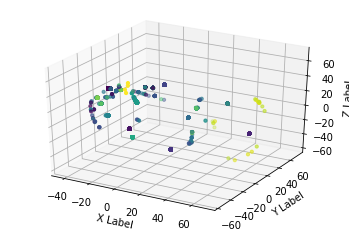

In [94]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scaleUp = 1000

x = data_3d_df['x']*scaleUp
y = data_3d_df['y']*scaleUp
z = data_3d_df['z']*scaleUp

ax.scatter(x, y, z, c=dbClusts['cluster'], s=10)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()